# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm 
plt.style.use('seaborn-whitegrid')
import time

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import inauguralproject

# Question 1

We answer question 1 in two ways: First by using scipy optimize to find optimal utility and next by defining our own algorithm that loops through all possibilities to find optimal utility.

#### Defining initial functions
Here we define the utility function that we aim to maximize as well as the budget constraint and the equilibrium condition.

In [2]:
def u(c, l):
    return np.log(c) - v * l **(1+1/eps) / (1+1/eps)

def bc(l, w):
    return m + w*l - (t_0 * w * l + t_1 * np.max(w * l - k, 0))

def equilibrium(l, w):
    c = bc(l, w)
    return -u(c, l)

Here we use the scipy optimize function to solve the labor supply problem for a wage of 1.

In [3]:
start = time.time()

w = 1
m = 1
v = 10
eps = 0.3
t_0 = 0.4
t_1 = 0.1
k = 0.4

res = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(w), method = "bounded")
l_star = res.x
c_star = bc(l_star,w)

print(f'Optimal labour supply: {l_star:.2f}')
print(f'Optimal consumption: {c_star:.2f}')
print(f'Utility: {u(c_star, l_star):.2f}')

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

Optimal labour supply: 0.38
Optimal consumption: 1.23
Utility: 0.17
Time elapsed: 0.0009636879 seconds


Here we define the optimization algorithm manually by looping through possibilities. We initialize by guessing of c=l=0. Then we loop through all possibilites of c and l (subject to the constraint) and save the combination of c and l that maximizes utility. 

In [4]:
def f(w, N=1000, do_print=True):
    
    # a. allocate numpy arrays
    shape_tuple = (N)
    c_values = np.empty(shape_tuple)
    l_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of c=l=0
    c_best = 0
    l_best = 0
    u_best = u(0,0)
    
    # c. loop through all possibilities
    for i in range(N):
        
        # i. l must be between 0 and 1
        l_values[i] = l = i/N
        
        # ii. implied c
        c_values[i] = c = m + w*l - (t_0 * w * l + t_1 * np.max(w * l - k, 0))
            
        # iii. utility    
        u_values[i] = u(c,l)
        
        if u_values[i] >= u_best:    
            c_best = c_values[i]
            l_best = l_values[i] 
            u_best = u_values[i]
            
    # d. print
    if do_print:
        print(f'Optimal labour supply: {l_best:.2f}')
        print(f'Optimal consumption: {c_best:.2f}')
        print(f'Utility: {u(c_best, l_best):.2f}')

    return c_best,l_best,u_best,c_values,l_values,u_values

We call the function for a wage of 1 and get the same result as before.

In [5]:
start = time.time()

m = 1
v = 10
eps = 0.3
t_0 = 0.4
t_1 = 0.1
k = 0.4

solve = f(w=1)

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

Optimal labour supply: 0.38
Optimal consumption: 1.23
Utility: 0.17
Time elapsed: 0.0101752281 seconds


C:\Users\Mathilde Bechmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


We find that both ways of solving the problem returns the correct result, however scipy optimize is faster, why we will use this function in the rest of the assignment.

# Question 2
We run the algorithm over a range of wages, $w\in [0.5,1.5]$

<function matplotlib.pyplot.show>

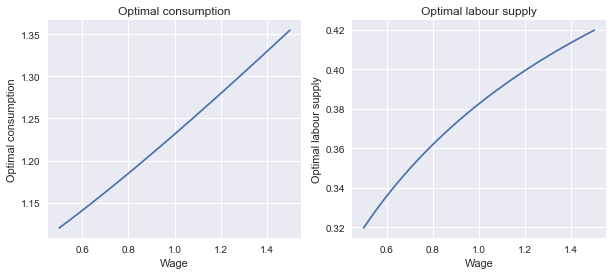

In [6]:
# a. allocate numpy arrays
wages = np.linspace(0.5,1.5,1000)
c_plot = np.empty(len(wages))
l_plot = np.empty(len(wages))

# b. find and save optimal c and l for each wage
for i,w in enumerate(wages):
    result = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(w), method = "bounded")
    l_plot[i] = result.x
    c_plot[i] = bc(l_plot[i],w)
    
# c. plot optimal l and c as functions of wage
plt.style.use('seaborn')
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.plot(wages, c_plot)
ax_left.set_title('Optimal consumption')
ax_left.set_xlabel('Wage')
ax_left.set_ylabel('Optimal consumption')
ax_left.grid(True)

ax_right = fig.add_subplot(1,2,2)
ax_right.plot(wages,l_plot)
ax_right.set_title('Optimal labour supply')
ax_right.set_xlabel('Wage')
ax_right.set_ylabel('Optimal labour supply')
ax_right.grid(True)

plt.show

# Question 3
We define a function to calculate tax revenue:

In [7]:
def tax_rev(pop_size):
    # a. assign numpy arrays
    wages = np.linspace(0.5,1.5,pop_size)
    l_star = np.empty(pop_size)
    # b. find optimal labor choice for each individual
    for i,w in enumerate(wages):
        res = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(w), method = "bounded")
        l_star[i] = res.x
    # c. sum tax revenue from each individual 
    tax_rev = np.sum(t_0*wages*l_star + t_1*np.max(wages*l_star-k,0))
    return tax_rev

And calculate the tax revenue for a population of 10.000 individuals and an epsilon of 0.3:

In [8]:
eps = 0.3
print(f'Tax revenue for epsilon = {eps:.1f} is: {tax_rev(pop_size = 10000):.2f}') 

Tax revenue for epsilon = 0.3 is: 1775.39


# Question 4
We calculate the tax revenue for a population of 10.000 individuals and an epsilon of 0.1:

In [9]:
eps = 0.1
print(f'Tax revenue for epsilon = {eps:.1f} is: {tax_rev(pop_size = 10000):.2f}') 

Tax revenue for epsilon = 0.1 is: 3578.90


# Question 5
We assume that the income taxes range between 0 and 1. 
We further assume that the cut-off for the top labor income bracket, $\kappa$ ranges from 0 to 1.5.
The reason is that as labor supply, $l$, has a maximum of 1 and wages have a maximum of 1.5, the maximal total wage is 1.5, implying that the maximal top labor income bracket is 1.5. 

We loop through values of tax rates and kappas to find the combination that maximizes tax revenue. 

We start by using the optimize function to maximize tax revenue:

In [10]:
def max_tax_rev(x):
    wages = np.linspace(0.5,1.5,10000)
    l_star = np.empty(10000)
    c_star = np.empty(10000)
    w = 1
    m = 1
    v = 10
    eps = 0.3
    
    t_0 = x[0]
    t_1 = x[1]
    k = x[2]
    
    # b. find optimal labor choice for each individual
    for i,w in enumerate(wages):
        res = optimize.minimize_scalar(equilibrium,bounds=(0,1),args=(w), method = "bounded")
        l_star[i] = res.x
        c_star[i] = bc(l_star[i],w)
    
    # c. sum tax revenue from each individual 
    rev = np.sum(x[0]*wages*l_star + x[1]*np.max(wages*l_star-x[2],0))
    return -rev

# Multivariate optimizer
# Initial guesses of [t_0, t_1, k]
x0 = np.array([1, 1, 1])

bounds = ((0,1),(0,1),(0,1.5))

res1 = optimize.minimize(max_tax_rev, x0, method = 'L-BFGS-B', bounds = bounds)
res2 = optimize.minimize(max_tax_rev, x0, method='SLSQP', bounds=bounds)


print('Method: L-BFGS-B')
print(f'Optimal tax revenue: {max_tax_rev(res1.x):.2f}') 
print(f'Optimal t_0: {res1.x[0]:.2f}')
print(f'Optimal t_1: {res1.x[1]:.2f}')
print(f'Optimal k: {res1.x[2]:.2f}')


print('Method: SLSQP')
print(f'Optimal tax revenue: {max_tax_rev(res2.x):.2f}') 
print(f'Optimal t_0: {res2.x[0]:.2f}')
print(f'Optimal t_1: {res2.x[1]:.2f}')
print(f'Optimal k: {res2.x[2]:.2f}')


Method: L-BFGS-B
Optimal tax revenue: -18235.24
Optimal t_0: 1.00
Optimal t_1: 1.00
Optimal k: 0.00
Method: SLSQP
Optimal tax revenue: -18232.50
Optimal t_0: 1.00
Optimal t_1: 1.00
Optimal k: 0.00


From this we find the maximal tax revenue by setting both tax rates to 1, which clearly does not make sense, as tax rates of 1 will eliminate the labor supply. Something is wrong in the above optimization. We cannot find the mistake, why we instead try to optimize tax revenue in the loop below.

In [11]:
start = time.time()
taxes = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
kappas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]

opt_rev = 0
opt_k = 0
opt_t1 = 0
opt_t0 = 0

# for tax_0 in taxes:
#     t_0 = tax_0
#     rev = tax_rev(pop_size = 10000)
#     if rev > opt_rev:
#         opt_rev = rev
#         opt_t0 = t_0

for tax_0 in taxes:
    for tax_1 in taxes:
        for ka in kappas:
            t_0 = tax_0
            t_1 = tax_1
            k = ka
            rev = tax_rev(pop_size = 10000)
            if rev > opt_rev:
                opt_rev = rev
                opt_k = k
                opt_t1 = t_1
                opt_t0 = t_0
                
print(f'Maximal tax revenue is: {opt_rev:.2f}')
print(f'Optimal t_0: {opt_t0:.2f}')
print(f'Optimal t_1: {opt_t1:.2f}')
print(f'Optimal k: {opt_k:.2f}')

end = time.time()
print(f'Time elapsed: {end - start:.10f} seconds')

Maximal tax revenue is: 8788.13
Optimal t_0: 0.00
Optimal t_1: 0.90
Optimal k: 0.00
Time elapsed: 14941.6665136814 seconds


Although the loop is quite time consuming, we find a more plausible result with a a maximum tax revenue of ... when we set t_0 = ..., t_1 = ... and k = ...

# Conclusion

In this assignment we have solved the labor supply problem using respectively the scipy optimize function and our own algorithm. The two methods return the same result. We have plotted the optimal consumption and labor supply as functions of wage and calculated tax revenue. Lastly, we have maximized tax revenue with respect to the labor income taxes and the cutoff for the top labor income bracket. 